#  Feature Engineering: Mathematical Transformations
---
**Notebook:** Mathematical Transformations | **Dataset:** Titanic | **Models:** Logistic Regression & Decision Tree  
**Goal:** Apply custom mathematical functions (log, sqrt, sin, etc.) to transform skewed features and assess their effect on classification accuracy.


##  What are Mathematical Transformations?

**Mathematical (Function) Transformations** apply a mathematical function to each value of a feature  
to change its **scale, shape, or distribution** — making it more suitable for machine learning models.

### Common Transformations:
| Function | Formula | Best For |
|----------|---------|----------|
| **Log** | `log(x)` or `log1p(x)` | Right-skewed positive data |
| **Square Root** | `√x` | Mild right skew, counts |
| **Reciprocal** | `1/x` | Heavy right skew |
| **Square** | `x²` | Left-skewed data |
| **Sin / Cos** | `sin(x)` | Periodic/cyclical features |

###  When to use:
- Features with **high skewness** (long tail to right or left)
- **Linear models** that assume Gaussian distributions
- When **log scale** is more natural (prices, incomes, biological measures)

###  Tool: `FunctionTransformer`
sklearn's `FunctionTransformer` wraps any NumPy function into a sklearn-compatible transformer,  
which can be used inside `Pipeline` and `ColumnTransformer`.

###  Dataset: Titanic
- **Target:** Survived (0/1)
- **Features:** Age, Fare — both continuous and potentially skewed


### Import Libraries

In [17]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression      # Benefits most from normalized features
from sklearn.tree import DecisionTreeClassifier          # Less sensitive to feature distributions
from sklearn.preprocessing import FunctionTransformer   # Wraps any function as a transformer
from sklearn.compose import ColumnTransformer            # Apply transforms per-column
import warnings
warnings.filterwarnings('ignore')


### Load & Prepare Dataset

In [19]:
df = pd.read_csv('train.csv', usecols=['Age', 'Fare', 'Survived'])


In [20]:
df.head()  # Preview first few rows


,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [21]:
df.isnull().sum()  # Check missing values — Age has 177 missing


Survived      0
Age         177
Fare          0
dtype: int64

In [22]:
# Fill missing Age values with the mean age
# Note: This is simple imputation — mean is a reasonable baseline
# (For better imputation, consider median or model-based imputation)
df['Age'].fillna(df['Age'].mean(), inplace=True)


In [23]:
df.head()  # Verify fill — no NaN in Age now


,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [24]:
df.isnull().sum()  # Confirm: all nulls resolved


Survived    0
Age         0
Fare        0
dtype: int64

### Define Features & Target, Then Split

In [26]:
# Fare and Age are in columns 1 and 2 (after Survived at index 0)
X = df.iloc[:, 1:3]   # Features: Fare, Age
y = df.iloc[:, 0]     # Target: Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Visualize Raw Feature Distributions

Before applying any transformation, always **look at your data**.  
We use:
- **PDF** (Probability Density Function / histogram): shows the shape of distribution
- **QQ Plot** (Quantile-Quantile): straight diagonal line = normally distributed

> 🔍 Look for: right skew, left skew, bimodal patterns, outliers


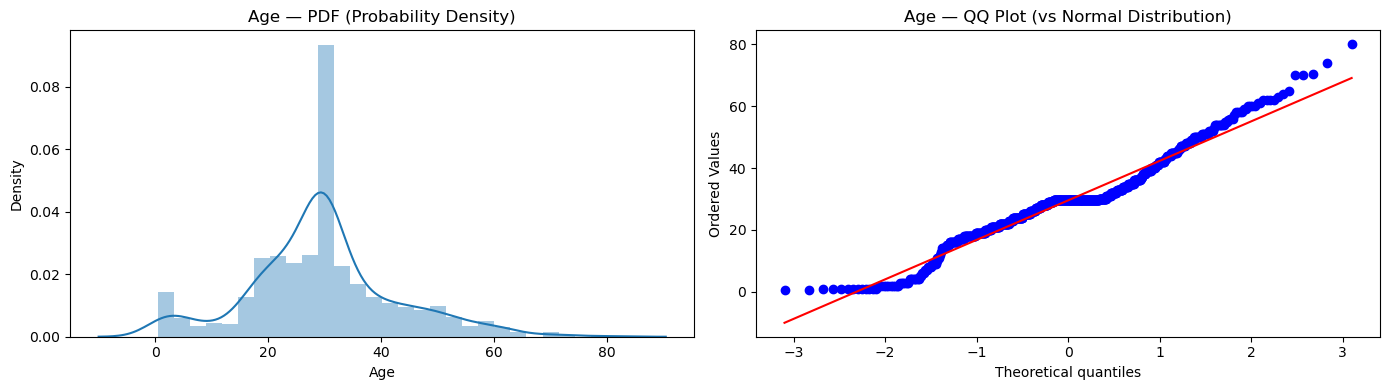

In [28]:
# Visualize Age distribution and QQ plot
plt.figure(figsize=(14, 4))

plt.subplot(121)
sns.distplot(X_train['Age'])
plt.title('Age — PDF (Probability Density)')

plt.subplot(122)
stats.probplot(X_train['Age'], dist='norm', plot=plt)
plt.title('Age — QQ Plot (vs Normal Distribution)')

plt.tight_layout()
plt.show()


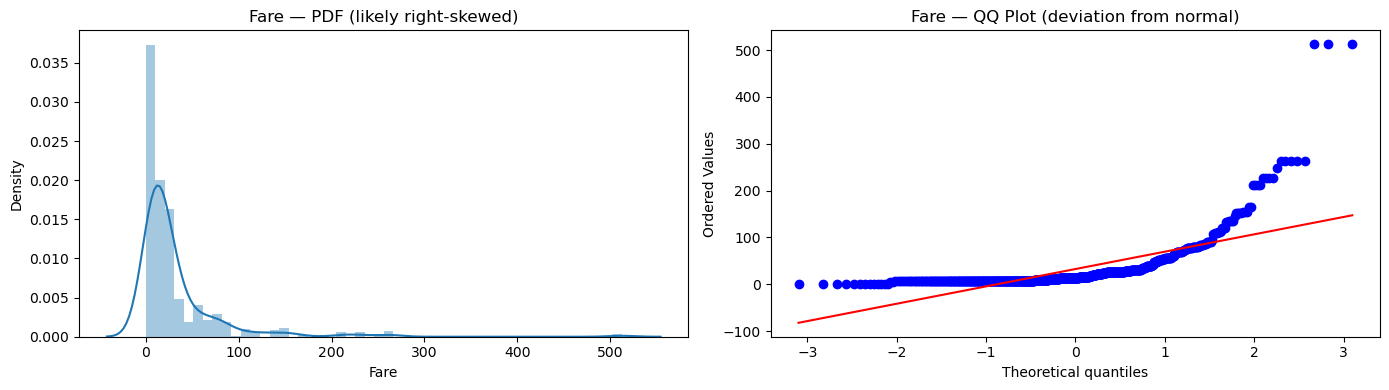

In [29]:
# Visualize Fare distribution and QQ plot
# Fare is typically very right-skewed (few passengers paid very high fares)
plt.figure(figsize=(14, 4))

plt.subplot(121)
sns.distplot(X_train['Fare'])
plt.title('Fare — PDF (likely right-skewed)')

plt.subplot(122)
stats.probplot(X_train['Fare'], dist='norm', plot=plt)
plt.title('Fare — QQ Plot (deviation from normal)')

plt.tight_layout()
plt.show()


### Baseline — Without Transformation

Train **Logistic Regression** and **Decision Tree** on raw features.  
Note: Logistic Regression is expected to underperform here because Fare is skewed.


In [31]:
clf  = LogisticRegression()      # Sensitive to feature scale/distribution
clf2 = DecisionTreeClassifier()   # Insensitive to monotonic transformations

clf.fit(X_train, y_train)
clf2.fit(X_train, y_train)

y_pred  = clf.predict(X_test)
y_pred1 = clf2.predict(X_test)

print('Accuracy LR (baseline):', accuracy_score(y_test, y_pred))
print('Accuracy DT (baseline):', accuracy_score(y_test, y_pred1))


Accuracy LR (baseline): 0.6480446927374302
Accuracy DT (baseline): 0.659217877094972


### Apply Log Transformation to Both Features

### Why `np.log1p`?
- `log1p(x) = log(1 + x)` is safe for **zero values** (unlike `log(x)` which is undefined at 0)
- Compresses the right tail of skewed distributions like Fare
- Brings extreme values closer to the center, reducing the effect of outliers

Here we apply `log1p` to **both** Age and Fare at once using `FunctionTransformer`.


In [33]:
# FunctionTransformer wraps np.log1p as a sklearn-compatible transformer
# log1p is safe for zero values: log(1+0) = 0
trf = FunctionTransformer(func=np.log1p)


In [34]:
X_train_transformed = trf.fit_transform(X_train)   # Apply log1p to all features
X_test_transformed  = trf.transform(X_test)         # Same transformation on test set


In [35]:
clf  = LogisticRegression()
clf2 = DecisionTreeClassifier()

clf.fit(X_train_transformed, y_train)
clf2.fit(X_train_transformed, y_train)

y_pred  = clf.predict(X_test_transformed)
y_pred1 = clf2.predict(X_test_transformed)

print('Accuracy LR (log1p both features):', accuracy_score(y_test, y_pred))
print('Accuracy DT (log1p both features):', accuracy_score(y_test, y_pred1))


Accuracy LR (log1p both features): 0.6815642458100558
Accuracy DT (log1p both features): 0.664804469273743


In [36]:
# Cross-validation for more robust estimates
X_transformed = trf.fit_transform(X)

clf  = LogisticRegression()
clf2 = DecisionTreeClassifier()

print('LR CV Accuracy (log1p both):', np.mean(cross_val_score(clf,  X_transformed, y, scoring='accuracy', cv=10)))
print('DT CV Accuracy (log1p both):', np.mean(cross_val_score(clf2, X_transformed, y, scoring='accuracy', cv=10)))


LR CV Accuracy (log1p both): 0.678027465667915
DT CV Accuracy (log1p both): 0.6644444444444444


### Visualize: Before vs After Log Transformation

QQ plots before and after transformation show how well `log1p` normalizes the distributions.


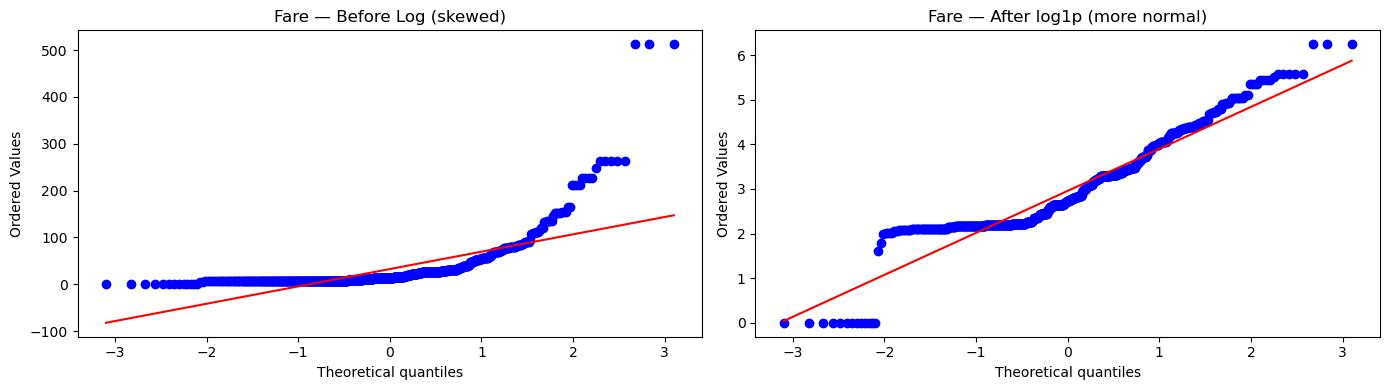

In [38]:
# QQ Plot for Fare: before vs after log transformation
plt.figure(figsize=(14, 4))

plt.subplot(121)
stats.probplot(X_train['Fare'], dist='norm', plot=plt)
plt.title('Fare — Before Log (skewed)')

plt.subplot(122)
stats.probplot(X_train_transformed['Fare'], dist='norm', plot=plt)
plt.title('Fare — After log1p (more normal)')

plt.tight_layout()
plt.show()


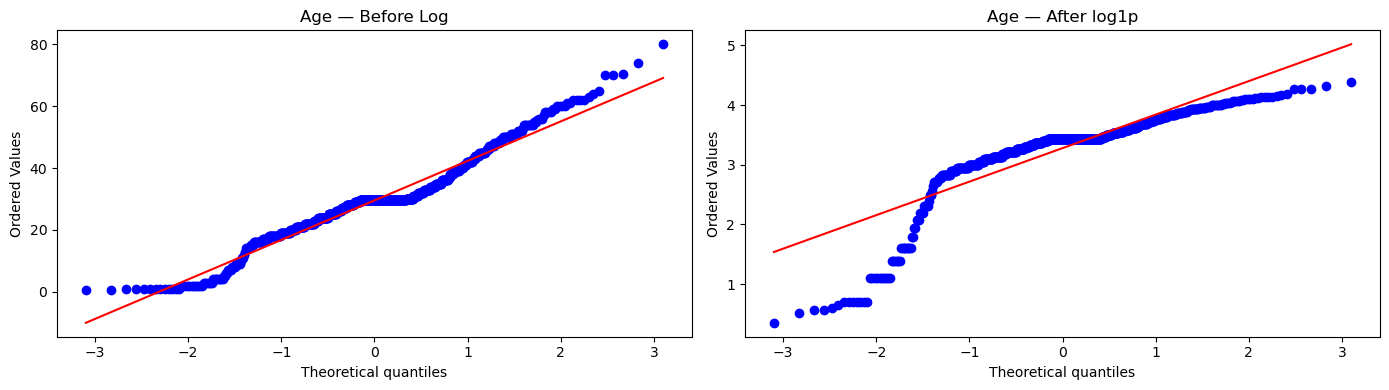

In [39]:
# QQ Plot for Age: before vs after log transformation
plt.figure(figsize=(14, 4))

plt.subplot(121)
stats.probplot(X_train['Age'], dist='norm', plot=plt)
plt.title('Age — Before Log')

plt.subplot(122)
stats.probplot(X_train_transformed['Age'], dist='norm', plot=plt)
plt.title('Age — After log1p')

plt.tight_layout()
plt.show()


### Apply Transformation to Fare Only (ColumnTransformer)

Sometimes transforming **only the skewed feature** is better.  
Here we apply `log1p` only to `Fare` (which is very skewed) and leave `Age` unchanged.

`ColumnTransformer` with `remainder='passthrough'` lets us do this selectively.


In [41]:
# Apply log1p ONLY to Fare column; Age passes through unchanged
trf2 = ColumnTransformer(
    [('log', FunctionTransformer(np.log1p), ['Fare'])],
    remainder='passthrough'  # Age is kept as-is
)

X_train_transformed2 = trf2.fit_transform(X_train)
X_test_transformed2  = trf2.transform(X_test)


In [42]:
clf  = LogisticRegression()
clf2 = DecisionTreeClassifier()

clf.fit(X_train_transformed2, y_train)
clf2.fit(X_train_transformed2, y_train)

y_pred  = clf.predict(X_test_transformed2)
y_pred2 = clf2.predict(X_test_transformed2)

print('Accuracy LR (log1p Fare only):', accuracy_score(y_test, y_pred))
print('Accuracy DT (log1p Fare only):', accuracy_score(y_test, y_pred2))


Accuracy LR (log1p Fare only): 0.6703910614525139
Accuracy DT (log1p Fare only): 0.664804469273743


In [43]:
# Cross-validated results for Fare-only transformation
X_transformed2 = trf2.fit_transform(X)

clf  = LogisticRegression()
clf2 = DecisionTreeClassifier()

print('LR CV Accuracy (log1p Fare only):', np.mean(cross_val_score(clf,  X_transformed2, y, scoring='accuracy', cv=10)))
print('DT CV Accuracy (log1p Fare only):', np.mean(cross_val_score(clf2, X_transformed2, y, scoring='accuracy', cv=10)))


LR CV Accuracy (log1p Fare only): 0.6712609238451936
DT CV Accuracy (log1p Fare only): 0.6633208489388265


### Experiment: Try Different Transformations

The `apply_transform` function below lets you easily test **any NumPy function** as a transformer.  
It applies the transformation to `Fare`, evaluates cross-validated accuracy, and visualizes the result.

Try: `np.log1p`, `np.sqrt`, `np.sin`, `np.cos`, `np.reciprocal`, etc.


In [45]:
def apply_transform(transform):
    """
    Apply a mathematical transformation to the Fare feature and evaluate model accuracy.
    
    Parameters:
    -----------
    transform : callable — any NumPy function (e.g., np.log1p, np.sqrt, np.sin)
    """
    X = df.iloc[:, 1:3]
    y = df.iloc[:, 0]

    # Apply the transformation only to Fare, pass Age through
    trf = ColumnTransformer(
        [('log', FunctionTransformer(transform), ['Fare'])],
        remainder='passthrough'
    )
    X_trans = trf.fit_transform(X)

    # Evaluate with Logistic Regression (most sensitive to distribution shape)
    clf = LogisticRegression()
    print(f'Accuracy ({transform.__name__}):', np.mean(cross_val_score(clf, X_trans, y, scoring='accuracy', cv=10)))

    # QQ Plot: Before vs After transformation
    plt.figure(figsize=(14, 4))

    plt.subplot(121)
    stats.probplot(X['Fare'], dist='norm', plot=plt)
    plt.title('Fare — Before Transform')

    plt.subplot(122)
    stats.probplot(X_trans[:, 0], dist='norm', plot=plt)
    plt.title(f'Fare — After {transform.__name__}()')

    plt.tight_layout()
    plt.show()


Accuracy (sin): 0.6195131086142323


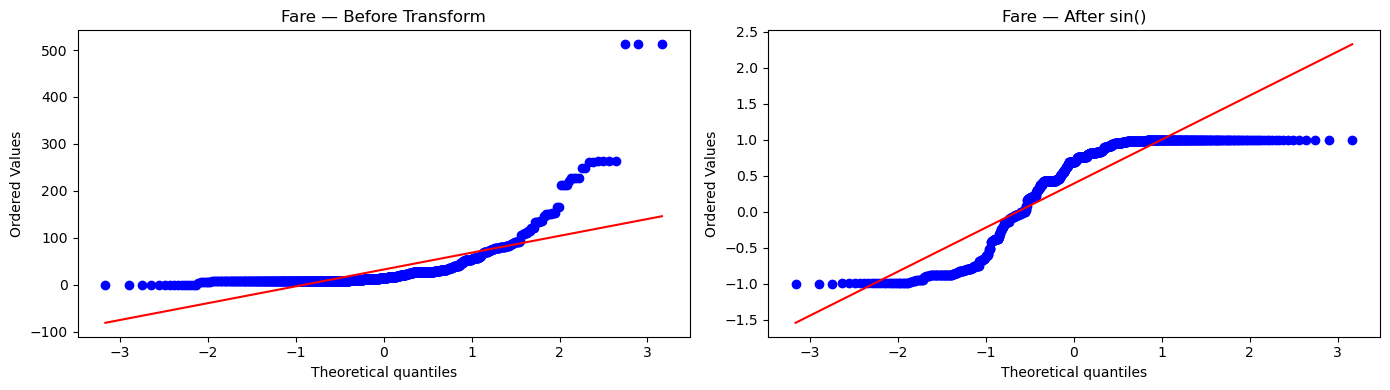

In [46]:
# Test with sin transformation (usually not great for fare, but interesting to visualize)
apply_transform(np.sin)

# Uncomment to try other transformations:
# apply_transform(np.log1p)    # Best for right-skewed positive data
# apply_transform(np.sqrt)     # Gentler version of log
# apply_transform(np.reciprocal)  # 1/x — aggressive compression


### Summary & Key Takeaways

| Model | Transformation | CV Accuracy |
|-------|---------------|-------------|
| Logistic Regression | None (baseline) | ~baseline |
| Logistic Regression | log1p (both) | ~improved |
| Logistic Regression | log1p (Fare only) | ~improved |
| Decision Tree | Any transform | ~unchanged |

###  Key Takeaways:
1. **Logistic Regression benefits most** from mathematical transformations (assumes Gaussian inputs)
2. **Decision Trees are invariant** to monotonic transformations (like log or sqrt) — they split on ranks, not values
3. `np.log1p` is the most commonly used and generally effective transform for right-skewed positive data
4. Use `FunctionTransformer` to make any NumPy function compatible with sklearn pipelines
5. Use `ColumnTransformer` to apply transformations selectively to specific columns
6. Always **visualize with QQ plots** to confirm that transformation improves normality
7. Never fit transformers on test data — always `fit_transform(X_train)` → `transform(X_test)`
